In [34]:
from sklearn import datasets
from sklearn.model_selection import KFold
# Load the TensorBoard notebook extension

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm


class SimpleMLP(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.fc_in = nn.Linear(in_features=4, out_features=5)
        self.fc2 = nn.Linear(in_features=5, out_features=7)
        self.fc_out = nn.Linear(in_features=7, out_features=n_classes)

    def forward(self, x, get_features=False):
        x = self.fc_in(x)
        x = F.relu(x)
        x = self.fc2(x)
        y = F.relu(x)
        x = self.fc_out(y)
        x = F.softmax(x, dim=1)
        if get_features:
            return x, y
        return x


def train(
    model,
    train_loader,
    valid_loader,
    optimizer,
    criterion,
    device,
    epochs=10,
    log_writer=None,
):

    history = {
        "train": {"loss": [], "accuracy": []},
        "valid": {"loss": [], "accuracy": []},
    }
    n = len(train_loader)
    model.to(device)
    for epoch in range(epochs):
        model.train()
        Loss_epoch = 0
        correct = 0
        total = 0
        evaluation_train = {"accuracy": 0, "loss": 0}
        for idx, data in enumerate(tqdm(train_loader)):
            input, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            output = model(input)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            Loss_epoch += loss.item() * len(labels)
            correct += accuracy(output, labels) * len(labels)
            total += len(labels)
        # Loss_history.append(Loss_epoch/n)
        evaluation_train["accuracy"] = correct / total
        evaluation_train["loss"] = Loss_epoch / total
        # evaluation_train = evaluate(model, train_loader,criterion, device)
        evaluation_valid, *_ = evaluate(model, valid_loader, criterion, device)
        print(f"epoch: {epoch}, train: {evaluation_train}, valid: {evaluation_valid}")

        history["train"]["accuracy"].append(evaluation_train["accuracy"])
        history["train"]["loss"].append(evaluation_train["loss"])
        history["valid"]["loss"].append(evaluation_valid["loss"])
        history["valid"]["accuracy"].append(evaluation_valid["accuracy"])

        if log_writer is not None:
            log_writer.log(
                {
                    "train/train_loss": (evaluation_train["loss"],epoch),
                    "train/train_accuracy": (evaluation_train["accuracy"],epoch),
                    "val/valid_loss": (evaluation_valid["loss"],epoch),
                    "val/valid_accuracy": (evaluation_valid["accuracy"],epoch),
                }
            )

    return history


def accuracy(output, labels):
    _, preds = torch.max(output, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)).item()


def evaluate(model, data_loader, criterion, device, return_preds=False,return_features=False):
    model.eval()
    Accuracy_history = []
    Loss_history = []
    PREDS = []
    features = []
    ground_truth = []
    with torch.no_grad():
        for idx, data in enumerate(data_loader):
            input, target = data[0].to(device), data[1].to(device)
            if return_features:
                output, feature = model(input, get_features=True)
                features.extend(feature.tolist())
            output = model(input)
            loss = criterion(output, target)
            Accuracy_history.append(accuracy(output, target))
            Loss_history.append(loss.item())
            if return_preds:
                # PREDS.extend(torch.max(output, dim=1)[1].tolist())
                PREDS.extend(output.tolist())
            ground_truth.extend(target.tolist())
    return {
        "accuracy": torch.mean(torch.Tensor(Accuracy_history)).item(),
        "loss": torch.mean(torch.Tensor(Loss_history)).item(),
    }, PREDS , features , ground_truth

In [36]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as tt
from sklearn.model_selection import train_test_split


class IRISDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x  # torch.Tensor(x,).unsqueeze(1).type(torch.FloatTensor)
        self.y = y  # torch.Tensor(y).type(torch.LongTensor)
        self.transform = transform

    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.x)

In [37]:
data = datasets.load_iris()
iris_X, iris_Y = data.data, data.target
classes = data.target_names
iris_X = iris_X.astype("float32")
iris_Y = iris_Y.astype("int64")

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
    
def get_features(model, data_loader, device,get_preds=False):
    model.eval()
    features = []
    labels = []
    preds = []
    with torch.no_grad():
        for idx, data in enumerate(data_loader):
            input, target = data[0].to(device), data[1].to(device)
            output = model(input, get_features=True)
            if get_preds:
                preds.extend(output[0].tolist())
            features.extend(output[1].tolist())
            labels.extend(target.tolist())
    return features, labels , preds

def plot_TSNE(X, Y,writer = None):
    X_embedded = TSNE(n_components=2, perplexity=min(20,len(X)) ,n_iter=1000).fit_transform(X)
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(111)
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=Y)
    plt.show()
    if writer is not None:
        writer.add_figure('TSNE',
                    fig  ,
                    global_step=0)
        # writer.close()
# classes = [0,1,2]
def add_pr_curve_tensorboard(class_index, test_probs, test_label, writer, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]
    
    writer.add_pr_curve(classes[class_index],
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)
    # writer.close()

Kfold: 0


  0%|          | 0/14 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:00<00:00, 178.94it/s]


epoch: 0, train: {'accuracy': 0.34814815940680327, 'loss': 1.0891609854168363}, valid: {'accuracy': 0.30000001192092896, 'loss': 1.065220832824707}


100%|██████████| 14/14 [00:00<00:00, 122.58it/s]


epoch: 1, train: {'accuracy': 0.34814815333595983, 'loss': 1.027412838406033}, valid: {'accuracy': 0.30000001192092896, 'loss': 1.0176094770431519}


100%|██████████| 14/14 [00:00<00:00, 265.34it/s]


epoch: 2, train: {'accuracy': 0.3777777823033156, 'loss': 0.9867871778982656}, valid: {'accuracy': 0.6000000238418579, 'loss': 1.0020688772201538}


100%|██████████| 14/14 [00:00<00:00, 325.27it/s]


epoch: 3, train: {'accuracy': 0.6740740824628759, 'loss': 0.9558302296532525}, valid: {'accuracy': 0.6000000238418579, 'loss': 0.9445433616638184}


100%|██████████| 14/14 [00:00<00:00, 281.58it/s]


epoch: 4, train: {'accuracy': 0.7481481432914734, 'loss': 0.9248615525386952}, valid: {'accuracy': 0.75, 'loss': 0.9108602404594421}


100%|██████████| 14/14 [00:00<00:00, 292.80it/s]


epoch: 5, train: {'accuracy': 0.8370370423352277, 'loss': 0.8911557352101361}, valid: {'accuracy': 0.75, 'loss': 0.8838258981704712}


100%|██████████| 14/14 [00:00<00:00, 351.54it/s]


epoch: 6, train: {'accuracy': 0.822222215157968, 'loss': 0.8559472538806774}, valid: {'accuracy': 0.800000011920929, 'loss': 0.8369773030281067}


100%|██████████| 14/14 [00:00<00:00, 270.27it/s]


epoch: 7, train: {'accuracy': 0.874074070541947, 'loss': 0.8177556947425559}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.8008211851119995}


100%|██████████| 14/14 [00:00<00:00, 296.90it/s]


epoch: 8, train: {'accuracy': 0.9111110943335073, 'loss': 0.774441988379867}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.7588639855384827}


100%|██████████| 14/14 [00:00<00:00, 320.21it/s]

epoch: 9, train: {'accuracy': 0.955555553789492, 'loss': 0.7326446727470115}, valid: {'accuracy': 0.949999988079071, 'loss': 0.7263798713684082}



100%|██████████| 14/14 [00:00<00:00, 143.74it/s]


epoch: 10, train: {'accuracy': 0.977777776894746, 'loss': 0.6997479884712784}, valid: {'accuracy': 0.949999988079071, 'loss': 0.6979913711547852}


100%|██████████| 14/14 [00:00<00:00, 255.61it/s]


epoch: 11, train: {'accuracy': 0.9703703633061161, 'loss': 0.6773835773821231}, valid: {'accuracy': 0.949999988079071, 'loss': 0.6817046403884888}


100%|██████████| 14/14 [00:00<00:00, 283.82it/s]


epoch: 12, train: {'accuracy': 0.9703703655136956, 'loss': 0.6593009719142208}, valid: {'accuracy': 0.949999988079071, 'loss': 0.6602807641029358}


100%|██████████| 14/14 [00:00<00:00, 224.92it/s]


epoch: 13, train: {'accuracy': 0.970370367721275, 'loss': 0.6480157949306347}, valid: {'accuracy': 0.949999988079071, 'loss': 0.645391583442688}


100%|██████████| 14/14 [00:00<00:00, 291.11it/s]


epoch: 14, train: {'accuracy': 0.970370367721275, 'loss': 0.6360075517936989}, valid: {'accuracy': 0.949999988079071, 'loss': 0.6448960900306702}


100%|██████████| 14/14 [00:00<00:00, 246.67it/s]


epoch: 15, train: {'accuracy': 0.9703703633061161, 'loss': 0.6290151962527523}, valid: {'accuracy': 0.949999988079071, 'loss': 0.6303509473800659}


100%|██████████| 14/14 [00:00<00:00, 327.24it/s]


epoch: 16, train: {'accuracy': 0.9703703633061161, 'loss': 0.6234661451092472}, valid: {'accuracy': 1.0, 'loss': 0.6157060265541077}


100%|██████████| 14/14 [00:00<00:00, 303.49it/s]


epoch: 17, train: {'accuracy': 0.977777776894746, 'loss': 0.6181815619821902}, valid: {'accuracy': 0.949999988079071, 'loss': 0.6234487295150757}


100%|██████████| 14/14 [00:00<00:00, 128.11it/s]


epoch: 18, train: {'accuracy': 0.970370367721275, 'loss': 0.6130134706143979}, valid: {'accuracy': 0.949999988079071, 'loss': 0.6101414561271667}


100%|██████████| 14/14 [00:00<00:00, 234.72it/s]


epoch: 19, train: {'accuracy': 0.970370367721275, 'loss': 0.6092076919696949}, valid: {'accuracy': 1.0, 'loss': 0.6047332882881165}


100%|██████████| 14/14 [00:00<00:00, 258.77it/s]


epoch: 20, train: {'accuracy': 0.970370367721275, 'loss': 0.6075593586321231}, valid: {'accuracy': 0.949999988079071, 'loss': 0.6094778776168823}


100%|██████████| 14/14 [00:00<00:00, 255.16it/s]


epoch: 21, train: {'accuracy': 0.9629629563402247, 'loss': 0.6026808001376964}, valid: {'accuracy': 1.0, 'loss': 0.5989089012145996}


100%|██████████| 14/14 [00:00<00:00, 293.23it/s]


epoch: 22, train: {'accuracy': 0.9851851816530581, 'loss': 0.6028173676243535}, valid: {'accuracy': 1.0, 'loss': 0.5935754776000977}


100%|██████████| 14/14 [00:00<00:00, 288.85it/s]


epoch: 23, train: {'accuracy': 0.9703703633061161, 'loss': 0.5980024492299115}, valid: {'accuracy': 1.0, 'loss': 0.5937774181365967}


100%|██████████| 14/14 [00:00<00:00, 313.46it/s]


epoch: 24, train: {'accuracy': 0.9703703633061161, 'loss': 0.5986572371588813}, valid: {'accuracy': 1.0, 'loss': 0.5900549292564392}


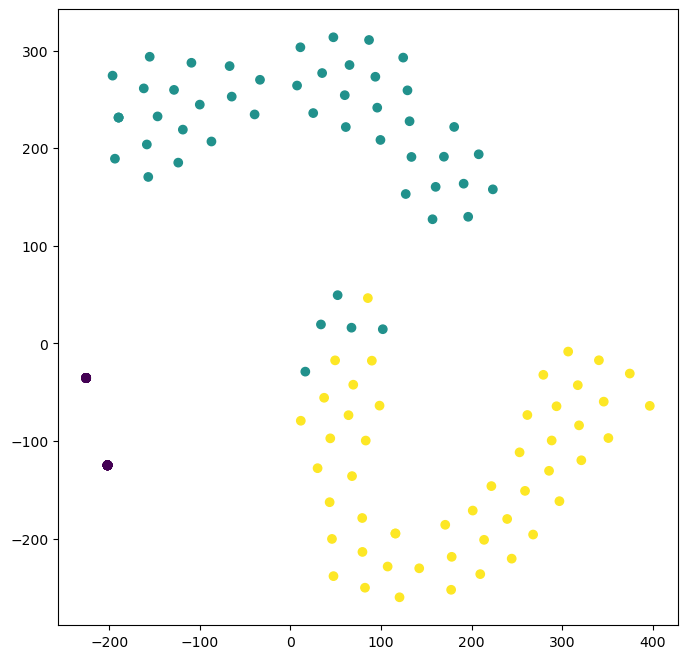

test accuracy: 1.0, test loss: 0.5992810726165771
Kfold: 1


100%|██████████| 14/14 [00:00<00:00, 230.39it/s]


epoch: 0, train: {'accuracy': 0.5407407471427211, 'loss': 1.0756881678545918}, valid: {'accuracy': 0.949999988079071, 'loss': 0.9883559346199036}


100%|██████████| 14/14 [00:00<00:00, 312.99it/s]


epoch: 1, train: {'accuracy': 0.7851851808804052, 'loss': 0.989567827295374}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.7757441997528076}


100%|██████████| 14/14 [00:00<00:00, 277.25it/s]


epoch: 2, train: {'accuracy': 0.6962962956340225, 'loss': 0.8960626301942048}, valid: {'accuracy': 0.8500000238418579, 'loss': 0.6938818693161011}


100%|██████████| 14/14 [00:00<00:00, 294.73it/s]


epoch: 3, train: {'accuracy': 0.7259259201862194, 'loss': 0.8042416793328745}, valid: {'accuracy': 0.949999988079071, 'loss': 0.6754699945449829}


100%|██████████| 14/14 [00:00<00:00, 264.87it/s]


epoch: 4, train: {'accuracy': 0.8444444366075374, 'loss': 0.768806431028578}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.6541041135787964}


100%|██████████| 14/14 [00:00<00:00, 222.66it/s]


epoch: 5, train: {'accuracy': 0.8740740661267881, 'loss': 0.7279270180949459}, valid: {'accuracy': 1.0, 'loss': 0.6744515895843506}


100%|██████████| 14/14 [00:00<00:00, 187.97it/s]


epoch: 6, train: {'accuracy': 0.970370367721275, 'loss': 0.6894733751261676}, valid: {'accuracy': 1.0, 'loss': 0.6289961934089661}


100%|██████████| 14/14 [00:00<00:00, 240.28it/s]


epoch: 7, train: {'accuracy': 0.9481481379932828, 'loss': 0.6601744161711799}, valid: {'accuracy': 1.0, 'loss': 0.6136884093284607}


100%|██████████| 14/14 [00:00<00:00, 208.24it/s]


epoch: 8, train: {'accuracy': 0.9703703633061161, 'loss': 0.6404568795804624}, valid: {'accuracy': 1.0, 'loss': 0.5857951045036316}


100%|██████████| 14/14 [00:00<00:00, 285.45it/s]


epoch: 9, train: {'accuracy': 0.9629629541326452, 'loss': 0.61838698387146}, valid: {'accuracy': 1.0, 'loss': 0.5806427597999573}


100%|██████████| 14/14 [00:00<00:00, 314.45it/s]


epoch: 10, train: {'accuracy': 0.9851851816530581, 'loss': 0.6082008039509809}, valid: {'accuracy': 1.0, 'loss': 0.5665645599365234}


100%|██████████| 14/14 [00:00<00:00, 417.03it/s]


epoch: 11, train: {'accuracy': 0.9629629585478041, 'loss': 0.6031574960108157}, valid: {'accuracy': 1.0, 'loss': 0.5687354803085327}


100%|██████████| 14/14 [00:00<00:00, 333.51it/s]


epoch: 12, train: {'accuracy': 0.9703703633061161, 'loss': 0.5974360108375549}, valid: {'accuracy': 1.0, 'loss': 0.5612396001815796}


100%|██████████| 14/14 [00:00<00:00, 286.44it/s]


epoch: 13, train: {'accuracy': 0.9629629541326452, 'loss': 0.5997338824801974}, valid: {'accuracy': 1.0, 'loss': 0.5587997436523438}


100%|██████████| 14/14 [00:00<00:00, 157.81it/s]


epoch: 14, train: {'accuracy': 0.9851851816530581, 'loss': 0.581864767604404}, valid: {'accuracy': 1.0, 'loss': 0.5735788345336914}


100%|██████████| 14/14 [00:00<00:00, 292.39it/s]


epoch: 15, train: {'accuracy': 0.977777776894746, 'loss': 0.5893338697927969}, valid: {'accuracy': 1.0, 'loss': 0.5571949481964111}


100%|██████████| 14/14 [00:00<00:00, 278.62it/s]


epoch: 16, train: {'accuracy': 0.9629629541326452, 'loss': 0.5863927271631029}, valid: {'accuracy': 1.0, 'loss': 0.5599948167800903}


100%|██████████| 14/14 [00:00<00:00, 273.98it/s]


epoch: 17, train: {'accuracy': 0.9703703633061161, 'loss': 0.5828654744006969}, valid: {'accuracy': 1.0, 'loss': 0.559330940246582}


100%|██████████| 14/14 [00:00<00:00, 282.53it/s]


epoch: 18, train: {'accuracy': 0.9629629585478041, 'loss': 0.5844771464665731}, valid: {'accuracy': 1.0, 'loss': 0.5576303005218506}


100%|██████████| 14/14 [00:00<00:00, 287.63it/s]


epoch: 19, train: {'accuracy': 0.9925925908265291, 'loss': 0.5813913234957943}, valid: {'accuracy': 1.0, 'loss': 0.5586609840393066}


100%|██████████| 14/14 [00:00<00:00, 366.37it/s]


epoch: 20, train: {'accuracy': 0.9851851816530581, 'loss': 0.5771431746306243}, valid: {'accuracy': 1.0, 'loss': 0.5539826154708862}


100%|██████████| 14/14 [00:00<00:00, 288.12it/s]


epoch: 21, train: {'accuracy': 0.970370367721275, 'loss': 0.5801856848928664}, valid: {'accuracy': 1.0, 'loss': 0.5583854913711548}


100%|██████████| 14/14 [00:00<00:00, 233.11it/s]


epoch: 22, train: {'accuracy': 0.9777777724795871, 'loss': 0.5789666595282378}, valid: {'accuracy': 1.0, 'loss': 0.5551600456237793}


100%|██████████| 14/14 [00:00<00:00, 228.29it/s]


epoch: 23, train: {'accuracy': 0.9777777724795871, 'loss': 0.5767836261678625}, valid: {'accuracy': 1.0, 'loss': 0.5569862127304077}


100%|██████████| 14/14 [00:00<00:00, 276.06it/s]


epoch: 24, train: {'accuracy': 0.9851851816530581, 'loss': 0.5770232456701773}, valid: {'accuracy': 1.0, 'loss': 0.554989218711853}


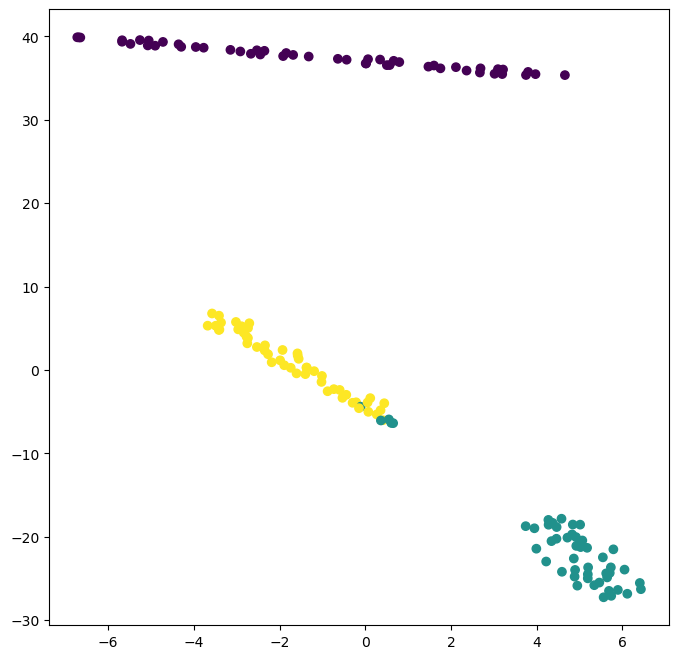

test accuracy: 1.0, test loss: 0.5559052228927612
Kfold: 2


100%|██████████| 14/14 [00:00<00:00, 232.74it/s]


epoch: 0, train: {'accuracy': 0.5629629680403957, 'loss': 1.0627249214384291}, valid: {'accuracy': 0.6499999761581421, 'loss': 0.9799511432647705}


100%|██████████| 14/14 [00:00<00:00, 202.50it/s]


epoch: 1, train: {'accuracy': 0.659259264115934, 'loss': 0.9513589496965762}, valid: {'accuracy': 0.6499999761581421, 'loss': 0.8611985445022583}


100%|██████████| 14/14 [00:00<00:00, 213.60it/s]


epoch: 2, train: {'accuracy': 0.6888888809416029, 'loss': 0.8373334496109573}, valid: {'accuracy': 0.6499999761581421, 'loss': 0.819135308265686}


100%|██████████| 14/14 [00:00<00:00, 152.27it/s]


epoch: 3, train: {'accuracy': 0.8370370268821716, 'loss': 0.7583477364646064}, valid: {'accuracy': 0.6499999761581421, 'loss': 0.7654620409011841}


100%|██████████| 14/14 [00:00<00:00, 190.32it/s]


epoch: 4, train: {'accuracy': 0.9407407266122324, 'loss': 0.6837737758954366}, valid: {'accuracy': 1.0, 'loss': 0.6722939610481262}


100%|██████████| 14/14 [00:00<00:00, 244.34it/s]


epoch: 5, train: {'accuracy': 0.9555555559970714, 'loss': 0.6391196537900854}, valid: {'accuracy': 1.0, 'loss': 0.6356652975082397}


100%|██████████| 14/14 [00:00<00:00, 311.86it/s]


epoch: 6, train: {'accuracy': 0.9481481402008621, 'loss': 0.6164995343596847}, valid: {'accuracy': 1.0, 'loss': 0.5996299982070923}


100%|██████████| 14/14 [00:00<00:00, 300.26it/s]


epoch: 7, train: {'accuracy': 0.9555555449591743, 'loss': 0.6063341520450733}, valid: {'accuracy': 1.0, 'loss': 0.5726486444473267}


100%|██████████| 14/14 [00:00<00:00, 397.45it/s]


epoch: 8, train: {'accuracy': 0.9703703655136956, 'loss': 0.5974890126122369}, valid: {'accuracy': 1.0, 'loss': 0.5632268190383911}


100%|██████████| 14/14 [00:00<00:00, 313.91it/s]


epoch: 9, train: {'accuracy': 0.970370367721275, 'loss': 0.5905621294622068}, valid: {'accuracy': 1.0, 'loss': 0.561177670955658}


100%|██████████| 14/14 [00:00<00:00, 364.50it/s]


epoch: 10, train: {'accuracy': 0.9629629541326452, 'loss': 0.5911960160290753}, valid: {'accuracy': 1.0, 'loss': 0.5590934157371521}


100%|██████████| 14/14 [00:00<00:00, 171.94it/s]


epoch: 11, train: {'accuracy': 0.9703703655136956, 'loss': 0.5867283675405714}, valid: {'accuracy': 1.0, 'loss': 0.5573808550834656}


100%|██████████| 14/14 [00:00<00:00, 285.96it/s]


epoch: 12, train: {'accuracy': 0.9851851860682169, 'loss': 0.5864583827831127}, valid: {'accuracy': 1.0, 'loss': 0.555729866027832}


100%|██████████| 14/14 [00:00<00:00, 259.45it/s]


epoch: 13, train: {'accuracy': 0.9629629585478041, 'loss': 0.5826216141382853}, valid: {'accuracy': 1.0, 'loss': 0.5560692548751831}


100%|██████████| 14/14 [00:00<00:00, 247.98it/s]


epoch: 14, train: {'accuracy': 0.9629629563402247, 'loss': 0.5876921967223838}, valid: {'accuracy': 1.0, 'loss': 0.555745542049408}


100%|██████████| 14/14 [00:00<00:00, 290.10it/s]


epoch: 15, train: {'accuracy': 0.9777777724795871, 'loss': 0.5824687017334832}, valid: {'accuracy': 1.0, 'loss': 0.5538116693496704}


100%|██████████| 14/14 [00:00<00:00, 343.51it/s]


epoch: 16, train: {'accuracy': 0.9629629629629629, 'loss': 0.58180449185548}, valid: {'accuracy': 1.0, 'loss': 0.5547778606414795}


100%|██████████| 14/14 [00:00<00:00, 253.89it/s]


epoch: 17, train: {'accuracy': 0.9851851838606375, 'loss': 0.5825065661359716}, valid: {'accuracy': 1.0, 'loss': 0.5534306764602661}


100%|██████████| 14/14 [00:00<00:00, 221.52it/s]


epoch: 18, train: {'accuracy': 0.9777777724795871, 'loss': 0.5829535479898806}, valid: {'accuracy': 1.0, 'loss': 0.5577583909034729}


100%|██████████| 14/14 [00:00<00:00, 231.07it/s]


epoch: 19, train: {'accuracy': 0.9777777724795871, 'loss': 0.579207283479196}, valid: {'accuracy': 1.0, 'loss': 0.5530338287353516}


100%|██████████| 14/14 [00:00<00:00, 314.44it/s]


epoch: 20, train: {'accuracy': 0.9777777724795871, 'loss': 0.5768288749235647}, valid: {'accuracy': 1.0, 'loss': 0.5526624917984009}


100%|██████████| 14/14 [00:00<00:00, 270.10it/s]


epoch: 21, train: {'accuracy': 0.9777777724795871, 'loss': 0.5747247669431899}, valid: {'accuracy': 1.0, 'loss': 0.5525530576705933}


100%|██████████| 14/14 [00:00<00:00, 237.50it/s]


epoch: 22, train: {'accuracy': 0.9777777724795871, 'loss': 0.5745772542776885}, valid: {'accuracy': 1.0, 'loss': 0.5522820949554443}


100%|██████████| 14/14 [00:00<00:00, 247.27it/s]


epoch: 23, train: {'accuracy': 0.9777777724795871, 'loss': 0.5744602503599944}, valid: {'accuracy': 1.0, 'loss': 0.5520601868629456}


100%|██████████| 14/14 [00:00<00:00, 292.10it/s]


epoch: 24, train: {'accuracy': 0.9777777724795871, 'loss': 0.5724667796382198}, valid: {'accuracy': 1.0, 'loss': 0.5522647500038147}


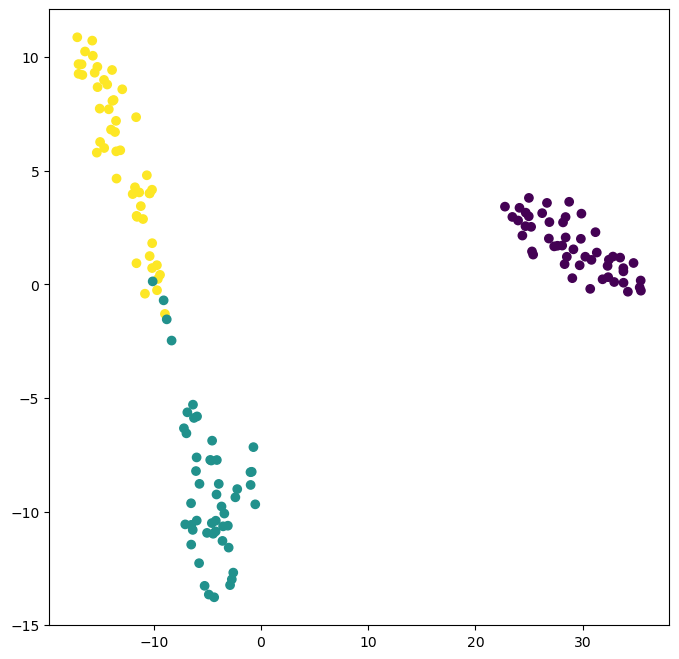

test accuracy: 1.0, test loss: 0.5520125031471252
Kfold: 3


100%|██████████| 14/14 [00:00<00:00, 145.44it/s]


epoch: 0, train: {'accuracy': 0.6000000050774327, 'loss': 1.0766333959720753}, valid: {'accuracy': 0.6000000238418579, 'loss': 1.0654741525650024}


100%|██████████| 14/14 [00:00<00:00, 253.09it/s]


epoch: 1, train: {'accuracy': 0.6518518604614116, 'loss': 0.9899652578212597}, valid: {'accuracy': 0.699999988079071, 'loss': 0.9688577651977539}


100%|██████████| 14/14 [00:00<00:00, 299.79it/s]


epoch: 2, train: {'accuracy': 0.6740740758401377, 'loss': 0.8773688629821494}, valid: {'accuracy': 0.699999988079071, 'loss': 0.8665087223052979}


100%|██████████| 14/14 [00:00<00:00, 321.35it/s]

epoch: 3, train: {'accuracy': 0.6740740725287685, 'loss': 0.8200048583525198}, valid: {'accuracy': 0.699999988079071, 'loss': 0.797731876373291}



100%|██████████| 14/14 [00:00<00:00, 302.54it/s]


epoch: 4, train: {'accuracy': 0.6888888919795001, 'loss': 0.7956979009840224}, valid: {'accuracy': 0.8500000238418579, 'loss': 0.7739951610565186}


100%|██████████| 14/14 [00:00<00:00, 237.33it/s]


epoch: 5, train: {'accuracy': 0.7333333426051669, 'loss': 0.7745894017042937}, valid: {'accuracy': 0.8500000238418579, 'loss': 0.7419474124908447}


100%|██████████| 14/14 [00:00<00:00, 264.28it/s]


epoch: 6, train: {'accuracy': 0.8296296265390184, 'loss': 0.7449325499711213}, valid: {'accuracy': 0.949999988079071, 'loss': 0.7126449346542358}


100%|██████████| 14/14 [00:00<00:00, 171.82it/s]


epoch: 7, train: {'accuracy': 0.9037036961979337, 'loss': 0.7029914988411797}, valid: {'accuracy': 1.0, 'loss': 0.6664440035820007}


100%|██████████| 14/14 [00:00<00:00, 335.33it/s]


epoch: 8, train: {'accuracy': 0.9333333218539203, 'loss': 0.664165077386079}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.6555682420730591}


100%|██████████| 14/14 [00:00<00:00, 298.62it/s]


epoch: 9, train: {'accuracy': 0.9481481379932828, 'loss': 0.6433831210489627}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.6434981822967529}


100%|██████████| 14/14 [00:00<00:00, 264.70it/s]


epoch: 10, train: {'accuracy': 0.9407407332349706, 'loss': 0.6289864910973443}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.632408857345581}


100%|██████████| 14/14 [00:00<00:00, 214.52it/s]


epoch: 11, train: {'accuracy': 0.9555555493743332, 'loss': 0.6118818963015521}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.6349912285804749}


100%|██████████| 14/14 [00:00<00:00, 252.70it/s]


epoch: 12, train: {'accuracy': 0.9555555515819125, 'loss': 0.6040553649266561}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.6268926858901978}


100%|██████████| 14/14 [00:00<00:00, 277.73it/s]


epoch: 13, train: {'accuracy': 0.9777777724795871, 'loss': 0.5989868199383771}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.6192281246185303}


100%|██████████| 14/14 [00:00<00:00, 167.38it/s]


epoch: 14, train: {'accuracy': 0.9629629585478041, 'loss': 0.5949898715372439}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.6311213970184326}


100%|██████████| 14/14 [00:00<00:00, 268.23it/s]


epoch: 15, train: {'accuracy': 0.9629629585478041, 'loss': 0.5935232815919099}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.6219500303268433}


100%|██████████| 14/14 [00:00<00:00, 294.97it/s]


epoch: 16, train: {'accuracy': 0.9555555515819125, 'loss': 0.5950308442115784}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.6334666013717651}


100%|██████████| 14/14 [00:00<00:00, 288.70it/s]


epoch: 17, train: {'accuracy': 0.9703703633061161, 'loss': 0.5897596566765396}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.6019541025161743}


100%|██████████| 14/14 [00:00<00:00, 272.01it/s]


epoch: 18, train: {'accuracy': 0.9777777724795871, 'loss': 0.5842813584539626}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.630061149597168}


100%|██████████| 14/14 [00:00<00:00, 337.33it/s]


epoch: 19, train: {'accuracy': 0.9629629585478041, 'loss': 0.5860258826503048}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.6304852962493896}


100%|██████████| 14/14 [00:00<00:00, 260.24it/s]


epoch: 20, train: {'accuracy': 0.977777776894746, 'loss': 0.584340426656935}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.6131401062011719}


100%|██████████| 14/14 [00:00<00:00, 185.95it/s]


epoch: 21, train: {'accuracy': 0.9555555493743332, 'loss': 0.588436711717535}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.6325595378875732}


100%|██████████| 14/14 [00:00<00:00, 281.89it/s]


epoch: 22, train: {'accuracy': 0.9555555449591743, 'loss': 0.5870330422012894}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.6090076565742493}


100%|██████████| 14/14 [00:00<00:00, 359.62it/s]


epoch: 23, train: {'accuracy': 0.9777777724795871, 'loss': 0.5793021762812579}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.6393711566925049}


100%|██████████| 14/14 [00:00<00:00, 274.42it/s]

epoch: 24, train: {'accuracy': 0.9629629541326452, 'loss': 0.5807387563917372}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.6167439222335815}


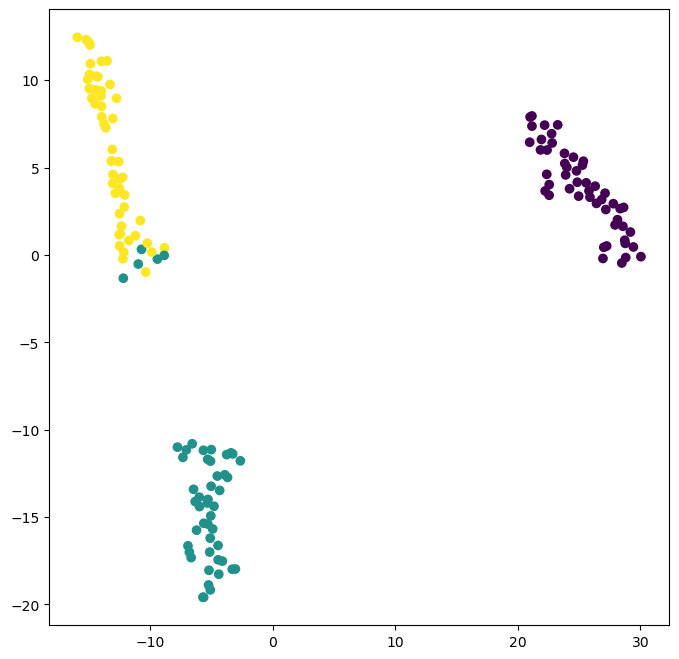

test accuracy: 0.9333333373069763, test loss: 0.596495509147644
Kfold: 4


100%|██████████| 14/14 [00:00<00:00, 253.48it/s]


epoch: 0, train: {'accuracy': 0.5481481574199818, 'loss': 1.0651847344857674}, valid: {'accuracy': 0.5, 'loss': 1.0201054811477661}


100%|██████████| 14/14 [00:00<00:00, 223.77it/s]


epoch: 1, train: {'accuracy': 0.6222222281826867, 'loss': 0.9498055511050754}, valid: {'accuracy': 0.5, 'loss': 0.9383985996246338}


100%|██████████| 14/14 [00:00<00:00, 200.10it/s]


epoch: 2, train: {'accuracy': 0.6444444457689921, 'loss': 0.8997683083569562}, valid: {'accuracy': 0.5, 'loss': 0.9131298065185547}


100%|██████████| 14/14 [00:00<00:00, 288.33it/s]


epoch: 3, train: {'accuracy': 0.6666666611477181, 'loss': 0.8777399416323062}, valid: {'accuracy': 0.5, 'loss': 0.8867920637130737}


100%|██████████| 14/14 [00:00<00:00, 214.21it/s]


epoch: 4, train: {'accuracy': 0.6666666710818255, 'loss': 0.8570041943479467}, valid: {'accuracy': 0.5, 'loss': 0.861652672290802}


100%|██████████| 14/14 [00:00<00:00, 272.24it/s]


epoch: 5, train: {'accuracy': 0.6666666754969844, 'loss': 0.8404841820398966}, valid: {'accuracy': 0.5, 'loss': 0.8538601994514465}


100%|██████████| 14/14 [00:00<00:00, 298.13it/s]


epoch: 6, train: {'accuracy': 0.6814814828060292, 'loss': 0.8306736173453154}, valid: {'accuracy': 0.6000000238418579, 'loss': 0.8519132137298584}


100%|██████████| 14/14 [00:00<00:00, 275.84it/s]


epoch: 7, train: {'accuracy': 0.6888888941870795, 'loss': 0.8222689451994719}, valid: {'accuracy': 0.6000000238418579, 'loss': 0.8445082902908325}


100%|██████████| 14/14 [00:00<00:00, 233.51it/s]


epoch: 8, train: {'accuracy': 0.7629629682611536, 'loss': 0.8070467136524342}, valid: {'accuracy': 0.6000000238418579, 'loss': 0.84092116355896}


100%|██████████| 14/14 [00:00<00:00, 191.44it/s]


epoch: 9, train: {'accuracy': 0.8296296221238596, 'loss': 0.7803089088863797}, valid: {'accuracy': 0.699999988079071, 'loss': 0.8084052801132202}


100%|██████████| 14/14 [00:00<00:00, 231.08it/s]


epoch: 10, train: {'accuracy': 0.851851847436693, 'loss': 0.7514936835677536}, valid: {'accuracy': 0.699999988079071, 'loss': 0.7652208805084229}


100%|██████████| 14/14 [00:00<00:00, 304.63it/s]


epoch: 11, train: {'accuracy': 0.8592592632329022, 'loss': 0.7163045803705851}, valid: {'accuracy': 0.800000011920929, 'loss': 0.7509558200836182}


100%|██████████| 14/14 [00:00<00:00, 268.27it/s]


epoch: 12, train: {'accuracy': 0.8740740661267881, 'loss': 0.6864030670236658}, valid: {'accuracy': 0.6000000238418579, 'loss': 0.7590122222900391}


100%|██████████| 14/14 [00:00<00:00, 271.15it/s]


epoch: 13, train: {'accuracy': 0.9259259126804493, 'loss': 0.6546437387113218}, valid: {'accuracy': 1.0, 'loss': 0.6530582904815674}


100%|██████████| 14/14 [00:00<00:00, 274.54it/s]


epoch: 14, train: {'accuracy': 0.9555555493743332, 'loss': 0.6245163370061804}, valid: {'accuracy': 1.0, 'loss': 0.6304879784584045}


100%|██████████| 14/14 [00:00<00:00, 282.50it/s]


epoch: 15, train: {'accuracy': 0.9555555449591743, 'loss': 0.606560574637519}, valid: {'accuracy': 1.0, 'loss': 0.6036043167114258}


100%|██████████| 14/14 [00:00<00:00, 184.82it/s]


epoch: 16, train: {'accuracy': 0.9777777746871665, 'loss': 0.5916752638640227}, valid: {'accuracy': 1.0, 'loss': 0.5947638154029846}


100%|██████████| 14/14 [00:00<00:00, 212.78it/s]


epoch: 17, train: {'accuracy': 0.9777777724795871, 'loss': 0.58629149640048}, valid: {'accuracy': 1.0, 'loss': 0.5894360542297363}


100%|██████████| 14/14 [00:00<00:00, 300.09it/s]


epoch: 18, train: {'accuracy': 0.9777777724795871, 'loss': 0.5829079945882162}, valid: {'accuracy': 1.0, 'loss': 0.5840896368026733}


100%|██████████| 14/14 [00:00<00:00, 249.29it/s]


epoch: 19, train: {'accuracy': 0.9777777724795871, 'loss': 0.5798852642377218}, valid: {'accuracy': 1.0, 'loss': 0.5897455215454102}


100%|██████████| 14/14 [00:00<00:00, 277.13it/s]


epoch: 20, train: {'accuracy': 0.9777777724795871, 'loss': 0.579153835773468}, valid: {'accuracy': 1.0, 'loss': 0.5942756533622742}


100%|██████████| 14/14 [00:00<00:00, 232.73it/s]


epoch: 21, train: {'accuracy': 0.9777777724795871, 'loss': 0.5775892535845438}, valid: {'accuracy': 1.0, 'loss': 0.5849239826202393}


100%|██████████| 14/14 [00:00<00:00, 271.61it/s]


epoch: 22, train: {'accuracy': 0.9777777724795871, 'loss': 0.5766312855261343}, valid: {'accuracy': 1.0, 'loss': 0.5767288208007812}


100%|██████████| 14/14 [00:00<00:00, 265.91it/s]


epoch: 23, train: {'accuracy': 0.9851851838606375, 'loss': 0.575309035954652}, valid: {'accuracy': 1.0, 'loss': 0.5799214839935303}


100%|██████████| 14/14 [00:00<00:00, 157.51it/s]


epoch: 24, train: {'accuracy': 0.9851851816530581, 'loss': 0.58138699443252}, valid: {'accuracy': 1.0, 'loss': 0.5872689485549927}


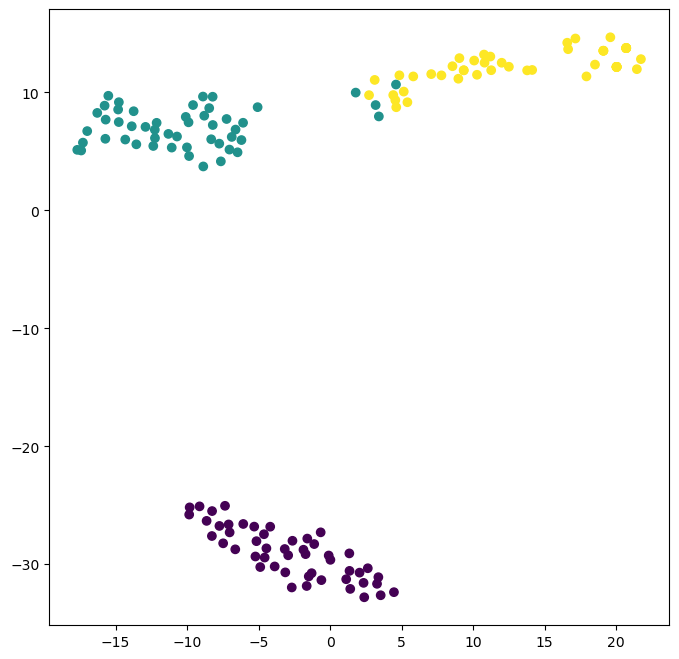

test accuracy: 1.0, test loss: 0.5754285454750061
Kfold: 5


100%|██████████| 14/14 [00:00<00:00, 264.87it/s]


epoch: 0, train: {'accuracy': 0.2962963001595603, 'loss': 1.0726630665637829}, valid: {'accuracy': 0.30000001192092896, 'loss': 1.0216801166534424}


100%|██████████| 14/14 [00:00<00:00, 203.40it/s]


epoch: 1, train: {'accuracy': 0.4592592616875966, 'loss': 0.9647884368896484}, valid: {'accuracy': 0.699999988079071, 'loss': 0.9189122915267944}


100%|██████████| 14/14 [00:00<00:00, 251.05it/s]


epoch: 2, train: {'accuracy': 0.6444444523917304, 'loss': 0.8868147995736864}, valid: {'accuracy': 0.699999988079071, 'loss': 0.8364707231521606}


100%|██████████| 14/14 [00:00<00:00, 189.14it/s]


epoch: 3, train: {'accuracy': 0.6518518571500425, 'loss': 0.8345962718681053}, valid: {'accuracy': 0.699999988079071, 'loss': 0.7970001697540283}


100%|██████████| 14/14 [00:00<00:00, 158.16it/s]


epoch: 4, train: {'accuracy': 0.7037036970809654, 'loss': 0.8037427332666185}, valid: {'accuracy': 0.8500000238418579, 'loss': 0.7655655145645142}


100%|██████████| 14/14 [00:00<00:00, 225.65it/s]


epoch: 5, train: {'accuracy': 0.9037036939903542, 'loss': 0.7645287734490854}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.7340127229690552}


100%|██████████| 14/14 [00:00<00:00, 275.04it/s]


epoch: 6, train: {'accuracy': 0.9481481490311799, 'loss': 0.7090482557261432}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.6944197416305542}


100%|██████████| 14/14 [00:00<00:00, 316.24it/s]

epoch: 7, train: {'accuracy': 0.9555555493743332, 'loss': 0.6570716897646586}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.6736825704574585}



100%|██████████| 14/14 [00:00<00:00, 361.58it/s]


epoch: 8, train: {'accuracy': 0.9777777724795871, 'loss': 0.6200005897769222}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.6481307744979858}


100%|██████████| 14/14 [00:00<00:00, 267.83it/s]


epoch: 9, train: {'accuracy': 0.9629629541326452, 'loss': 0.6053209702173868}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.6585016250610352}


100%|██████████| 14/14 [00:00<00:00, 278.23it/s]


epoch: 10, train: {'accuracy': 0.9851851816530581, 'loss': 0.5935075172671566}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.6539189219474792}


100%|██████████| 14/14 [00:00<00:00, 175.82it/s]


epoch: 11, train: {'accuracy': 0.9777777724795871, 'loss': 0.584494498040941}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.6343352794647217}


100%|██████████| 14/14 [00:00<00:00, 237.89it/s]


epoch: 12, train: {'accuracy': 0.970370367721275, 'loss': 0.5808480580647787}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.6365825533866882}


100%|██████████| 14/14 [00:00<00:00, 271.42it/s]


epoch: 13, train: {'accuracy': 0.9777777724795871, 'loss': 0.5809390257906031}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.6357895731925964}


100%|██████████| 14/14 [00:00<00:00, 265.80it/s]


epoch: 14, train: {'accuracy': 0.9777777724795871, 'loss': 0.5777189554991545}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.6369798183441162}


100%|██████████| 14/14 [00:00<00:00, 270.53it/s]


epoch: 15, train: {'accuracy': 0.9851851816530581, 'loss': 0.5771868030230204}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.6399731636047363}


100%|██████████| 14/14 [00:00<00:00, 332.47it/s]


epoch: 16, train: {'accuracy': 0.9777777724795871, 'loss': 0.5757037975169994}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.6418233513832092}


100%|██████████| 14/14 [00:00<00:00, 262.00it/s]


epoch: 17, train: {'accuracy': 0.9851851816530581, 'loss': 0.5740086325892696}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.6319359540939331}


100%|██████████| 14/14 [00:00<00:00, 208.38it/s]


epoch: 18, train: {'accuracy': 0.9851851816530581, 'loss': 0.5728940676759791}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.6372513771057129}


100%|██████████| 14/14 [00:00<00:00, 243.56it/s]


epoch: 19, train: {'accuracy': 0.9851851816530581, 'loss': 0.5719404816627502}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.6352325677871704}


100%|██████████| 14/14 [00:00<00:00, 268.55it/s]


epoch: 20, train: {'accuracy': 0.9777777724795871, 'loss': 0.5740127982916655}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.636709988117218}


100%|██████████| 14/14 [00:00<00:00, 237.44it/s]


epoch: 21, train: {'accuracy': 0.9851851816530581, 'loss': 0.5718842148780823}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.6484133005142212}


100%|██████████| 14/14 [00:00<00:00, 271.98it/s]


epoch: 22, train: {'accuracy': 0.9925925908265291, 'loss': 0.569496786152875}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.6379454135894775}


100%|██████████| 14/14 [00:00<00:00, 232.70it/s]


epoch: 23, train: {'accuracy': 0.9851851816530581, 'loss': 0.569928542331413}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.6305246353149414}


100%|██████████| 14/14 [00:00<00:00, 368.98it/s]


epoch: 24, train: {'accuracy': 0.977777776894746, 'loss': 0.5709873349578293}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.6420067548751831}


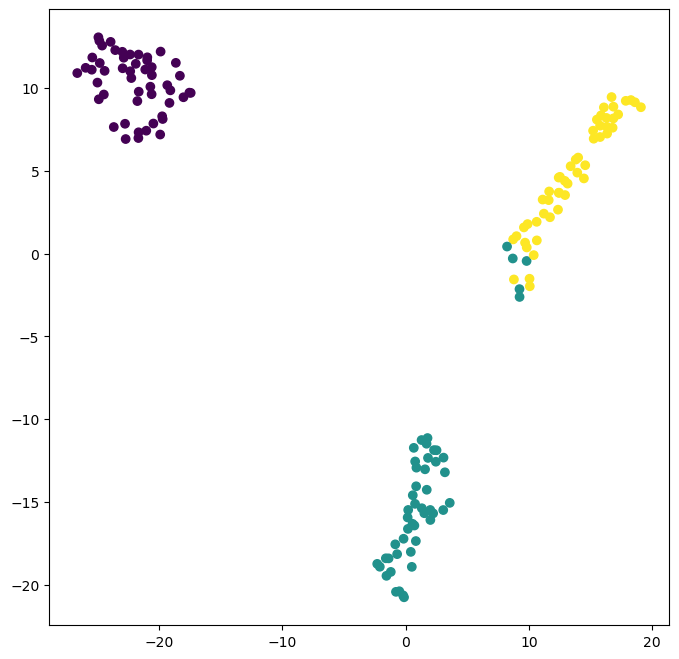

test accuracy: 0.8666666746139526, test loss: 0.6682263612747192
Kfold: 6


100%|██████████| 14/14 [00:00<00:00, 246.63it/s]


epoch: 0, train: {'accuracy': 0.674074078047717, 'loss': 1.0590657039924904}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.9564248323440552}


100%|██████████| 14/14 [00:00<00:00, 244.92it/s]


epoch: 1, train: {'accuracy': 0.7777777733626189, 'loss': 0.9413710567686293}, valid: {'accuracy': 0.8500000238418579, 'loss': 0.8091484308242798}


100%|██████████| 14/14 [00:00<00:00, 210.36it/s]


epoch: 2, train: {'accuracy': 0.7333333315672698, 'loss': 0.8941186313275937}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.7782214879989624}


100%|██████████| 14/14 [00:00<00:00, 272.15it/s]


epoch: 3, train: {'accuracy': 0.8888888778509917, 'loss': 0.8114946506641529}, valid: {'accuracy': 0.8500000238418579, 'loss': 0.7309496998786926}


100%|██████████| 14/14 [00:00<00:00, 358.04it/s]


epoch: 4, train: {'accuracy': 0.903703698405513, 'loss': 0.7235767973793877}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.6948516368865967}


100%|██████████| 14/14 [00:00<00:00, 171.84it/s]


epoch: 5, train: {'accuracy': 0.9481481379932828, 'loss': 0.665595288629885}, valid: {'accuracy': 0.8500000238418579, 'loss': 0.6990392804145813}


100%|██████████| 14/14 [00:00<00:00, 230.67it/s]


epoch: 6, train: {'accuracy': 0.9703703633061161, 'loss': 0.6347519821590848}, valid: {'accuracy': 0.949999988079071, 'loss': 0.6661427021026611}


100%|██████████| 14/14 [00:00<00:00, 267.18it/s]


epoch: 7, train: {'accuracy': 0.9777777724795871, 'loss': 0.6128080597630253}, valid: {'accuracy': 0.8500000238418579, 'loss': 0.6668047308921814}


100%|██████████| 14/14 [00:00<00:00, 329.83it/s]


epoch: 8, train: {'accuracy': 0.9777777746871665, 'loss': 0.5981457984005963}, valid: {'accuracy': 0.8500000238418579, 'loss': 0.6636478900909424}


100%|██████████| 14/14 [00:00<00:00, 234.07it/s]


epoch: 9, train: {'accuracy': 0.977777776894746, 'loss': 0.5893196596039666}, valid: {'accuracy': 0.8500000238418579, 'loss': 0.6685282588005066}


100%|██████████| 14/14 [00:00<00:00, 238.80it/s]


epoch: 10, train: {'accuracy': 0.970370367721275, 'loss': 0.5862123988292836}, valid: {'accuracy': 0.8500000238418579, 'loss': 0.6569219827651978}


100%|██████████| 14/14 [00:00<00:00, 242.95it/s]


epoch: 11, train: {'accuracy': 0.9703703633061161, 'loss': 0.5870606943413064}, valid: {'accuracy': 0.8500000238418579, 'loss': 0.6612424850463867}


100%|██████████| 14/14 [00:00<00:00, 160.63it/s]


epoch: 12, train: {'accuracy': 0.9777777724795871, 'loss': 0.5850694400292856}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.6457775831222534}


100%|██████████| 14/14 [00:00<00:00, 245.94it/s]


epoch: 13, train: {'accuracy': 0.9777777724795871, 'loss': 0.5798844408105921}, valid: {'accuracy': 0.800000011920929, 'loss': 0.6759396195411682}


100%|██████████| 14/14 [00:00<00:00, 312.74it/s]


epoch: 14, train: {'accuracy': 0.9777777746871665, 'loss': 0.5775124541035405}, valid: {'accuracy': 0.949999988079071, 'loss': 0.6463178396224976}


100%|██████████| 14/14 [00:00<00:00, 288.09it/s]


epoch: 15, train: {'accuracy': 0.9777777746871665, 'loss': 0.5773401768119247}, valid: {'accuracy': 0.949999988079071, 'loss': 0.6471586227416992}


100%|██████████| 14/14 [00:00<00:00, 274.67it/s]


epoch: 16, train: {'accuracy': 0.9777777724795871, 'loss': 0.5771519607967801}, valid: {'accuracy': 0.949999988079071, 'loss': 0.6463780403137207}


100%|██████████| 14/14 [00:00<00:00, 289.10it/s]


epoch: 17, train: {'accuracy': 0.9777777724795871, 'loss': 0.5744788072727345}, valid: {'accuracy': 0.949999988079071, 'loss': 0.6411256790161133}


100%|██████████| 14/14 [00:00<00:00, 354.79it/s]


epoch: 18, train: {'accuracy': 0.9777777724795871, 'loss': 0.5773001931331776}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.6381220817565918}


100%|██████████| 14/14 [00:00<00:00, 182.52it/s]


epoch: 19, train: {'accuracy': 0.9777777724795871, 'loss': 0.5764232697310271}, valid: {'accuracy': 0.949999988079071, 'loss': 0.6356850266456604}


100%|██████████| 14/14 [00:00<00:00, 277.73it/s]


epoch: 20, train: {'accuracy': 0.9777777724795871, 'loss': 0.5738748157465899}, valid: {'accuracy': 0.949999988079071, 'loss': 0.6364487409591675}


100%|██████████| 14/14 [00:00<00:00, 258.41it/s]


epoch: 21, train: {'accuracy': 0.9777777724795871, 'loss': 0.5741858062920747}, valid: {'accuracy': 0.949999988079071, 'loss': 0.6366121768951416}


100%|██████████| 14/14 [00:00<00:00, 270.80it/s]


epoch: 22, train: {'accuracy': 0.9629629585478041, 'loss': 0.5816869404580858}, valid: {'accuracy': 0.949999988079071, 'loss': 0.6351712942123413}


100%|██████████| 14/14 [00:00<00:00, 325.37it/s]


epoch: 23, train: {'accuracy': 0.9777777724795871, 'loss': 0.577611592080858}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.6399152278900146}


100%|██████████| 14/14 [00:00<00:00, 285.28it/s]


epoch: 24, train: {'accuracy': 0.9851851816530581, 'loss': 0.5750963224305047}, valid: {'accuracy': 0.800000011920929, 'loss': 0.67322838306427}


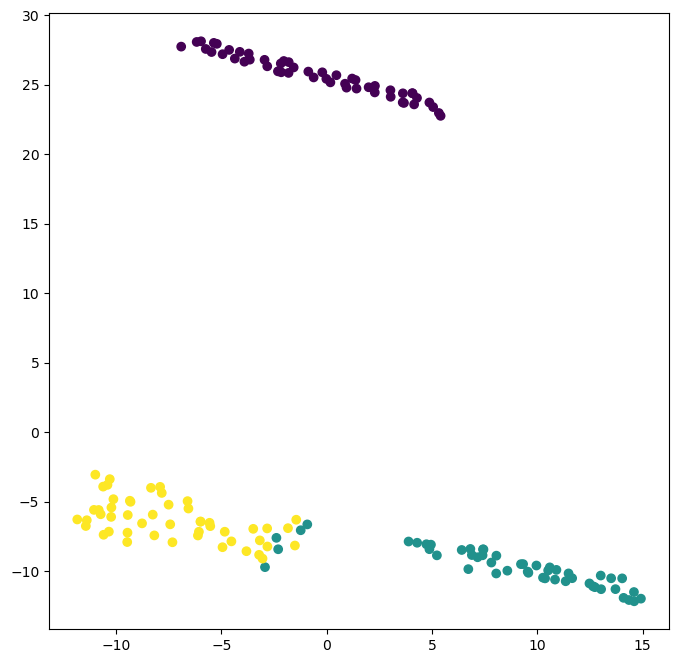

test accuracy: 0.800000011920929, test loss: 0.6725307106971741
Kfold: 7


100%|██████████| 14/14 [00:00<00:00, 165.80it/s]


epoch: 0, train: {'accuracy': 0.58518519004186, 'loss': 1.042986688790498}, valid: {'accuracy': 0.699999988079071, 'loss': 1.0249935388565063}


100%|██████████| 14/14 [00:00<00:00, 187.85it/s]


epoch: 1, train: {'accuracy': 0.674074078047717, 'loss': 0.9329029432049504}, valid: {'accuracy': 0.699999988079071, 'loss': 0.9897788763046265}


100%|██████████| 14/14 [00:00<00:00, 206.06it/s]


epoch: 2, train: {'accuracy': 0.674074078047717, 'loss': 0.8934792191893967}, valid: {'accuracy': 0.699999988079071, 'loss': 0.9654375314712524}


100%|██████████| 14/14 [00:00<00:00, 260.53it/s]


epoch: 3, train: {'accuracy': 0.6740740802552965, 'loss': 0.8773463280112656}, valid: {'accuracy': 0.699999988079071, 'loss': 0.9458987712860107}


100%|██████████| 14/14 [00:00<00:00, 204.02it/s]


epoch: 4, train: {'accuracy': 0.6888888941870795, 'loss': 0.8621580689041702}, valid: {'accuracy': 0.75, 'loss': 0.9273427724838257}


100%|██████████| 14/14 [00:00<00:00, 348.23it/s]


epoch: 5, train: {'accuracy': 0.807407401226185, 'loss': 0.8428818252351549}, valid: {'accuracy': 1.0, 'loss': 0.9057433605194092}


100%|██████████| 14/14 [00:00<00:00, 235.00it/s]


epoch: 6, train: {'accuracy': 0.9407407310273912, 'loss': 0.8162731020538895}, valid: {'accuracy': 1.0, 'loss': 0.8714421987533569}


100%|██████████| 14/14 [00:00<00:00, 216.83it/s]


epoch: 7, train: {'accuracy': 0.925925921510767, 'loss': 0.784463248870991}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.8350046277046204}


100%|██████████| 14/14 [00:00<00:00, 264.00it/s]


epoch: 8, train: {'accuracy': 0.9407407310273912, 'loss': 0.7401802208688524}, valid: {'accuracy': 1.0, 'loss': 0.787041425704956}


100%|██████████| 14/14 [00:00<00:00, 252.21it/s]


epoch: 9, train: {'accuracy': 0.9629629585478041, 'loss': 0.7079040805498759}, valid: {'accuracy': 1.0, 'loss': 0.7498934268951416}


100%|██████████| 14/14 [00:00<00:00, 250.45it/s]


epoch: 10, train: {'accuracy': 0.9703703699288545, 'loss': 0.6917101851216069}, valid: {'accuracy': 1.0, 'loss': 0.7123532295227051}


100%|██████████| 14/14 [00:00<00:00, 260.95it/s]


epoch: 11, train: {'accuracy': 0.9333333262690792, 'loss': 0.6766548024283515}, valid: {'accuracy': 1.0, 'loss': 0.6849706172943115}


100%|██████████| 14/14 [00:00<00:00, 225.66it/s]


epoch: 12, train: {'accuracy': 0.9777777724795871, 'loss': 0.6497755425947683}, valid: {'accuracy': 1.0, 'loss': 0.668044924736023}


100%|██████████| 14/14 [00:00<00:00, 237.59it/s]


epoch: 13, train: {'accuracy': 0.9777777724795871, 'loss': 0.6394442386097379}, valid: {'accuracy': 1.0, 'loss': 0.6507476568222046}


100%|██████████| 14/14 [00:00<00:00, 168.68it/s]


epoch: 14, train: {'accuracy': 0.9851851816530581, 'loss': 0.6287903123431735}, valid: {'accuracy': 1.0, 'loss': 0.6433678865432739}


100%|██████████| 14/14 [00:00<00:00, 257.36it/s]


epoch: 15, train: {'accuracy': 0.9777777724795871, 'loss': 0.6216968408337346}, valid: {'accuracy': 1.0, 'loss': 0.6276644468307495}


100%|██████████| 14/14 [00:00<00:00, 310.95it/s]


epoch: 16, train: {'accuracy': 0.9629629563402247, 'loss': 0.6183814384319164}, valid: {'accuracy': 1.0, 'loss': 0.6188893914222717}


100%|██████████| 14/14 [00:00<00:00, 351.75it/s]


epoch: 17, train: {'accuracy': 0.9777777724795871, 'loss': 0.6122378530325713}, valid: {'accuracy': 1.0, 'loss': 0.6215500831604004}


100%|██████████| 14/14 [00:00<00:00, 254.24it/s]


epoch: 18, train: {'accuracy': 0.9851851816530581, 'loss': 0.6050820505177533}, valid: {'accuracy': 1.0, 'loss': 0.6098350286483765}


100%|██████████| 14/14 [00:00<00:00, 250.87it/s]


epoch: 19, train: {'accuracy': 0.9851851816530581, 'loss': 0.6029903160201179}, valid: {'accuracy': 1.0, 'loss': 0.604282021522522}


100%|██████████| 14/14 [00:00<00:00, 181.07it/s]


epoch: 20, train: {'accuracy': 0.9851851860682169, 'loss': 0.5999715880111411}, valid: {'accuracy': 1.0, 'loss': 0.6016093492507935}


100%|██████████| 14/14 [00:00<00:00, 225.70it/s]


epoch: 21, train: {'accuracy': 0.9777777724795871, 'loss': 0.5975141459041171}, valid: {'accuracy': 1.0, 'loss': 0.5965543985366821}


100%|██████████| 14/14 [00:00<00:00, 370.22it/s]


epoch: 22, train: {'accuracy': 0.970370367721275, 'loss': 0.5977410166351883}, valid: {'accuracy': 1.0, 'loss': 0.599860668182373}


100%|██████████| 14/14 [00:00<00:00, 345.82it/s]


epoch: 23, train: {'accuracy': 0.9925925908265291, 'loss': 0.5914562984749123}, valid: {'accuracy': 1.0, 'loss': 0.58962082862854}


100%|██████████| 14/14 [00:00<00:00, 347.01it/s]


epoch: 24, train: {'accuracy': 0.9777777724795871, 'loss': 0.5917820466889275}, valid: {'accuracy': 1.0, 'loss': 0.5887430906295776}


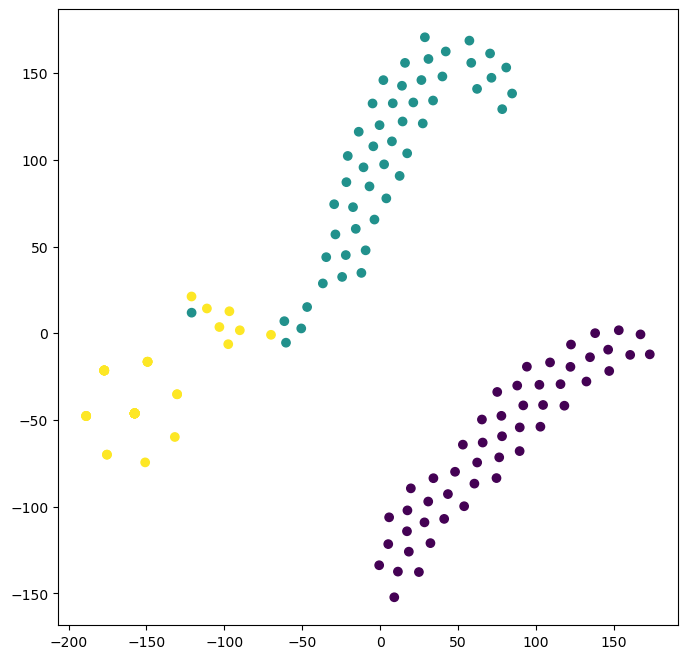

test accuracy: 1.0, test loss: 0.5798788666725159
Kfold: 8


100%|██████████| 14/14 [00:00<00:00, 166.18it/s]


epoch: 0, train: {'accuracy': 0.4518518618963383, 'loss': 1.0819864891193531}, valid: {'accuracy': 0.75, 'loss': 1.0346797704696655}


100%|██████████| 14/14 [00:00<00:00, 196.60it/s]


epoch: 1, train: {'accuracy': 0.6740740769439273, 'loss': 0.9823605616887411}, valid: {'accuracy': 0.75, 'loss': 0.8756513595581055}


100%|██████████| 14/14 [00:00<00:00, 275.13it/s]


epoch: 2, train: {'accuracy': 0.7185185110127484, 'loss': 0.835250457127889}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.7402886152267456}


100%|██████████| 14/14 [00:00<00:00, 236.37it/s]


epoch: 3, train: {'accuracy': 0.7703703663967274, 'loss': 0.7765662758438675}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.6941087245941162}


100%|██████████| 14/14 [00:00<00:00, 349.93it/s]


epoch: 4, train: {'accuracy': 0.8592592566101639, 'loss': 0.7386318312750922}, valid: {'accuracy': 0.8999999761581421, 'loss': 0.6706210374832153}


100%|██████████| 14/14 [00:00<00:00, 346.78it/s]


epoch: 5, train: {'accuracy': 0.888888869020674, 'loss': 0.7034118263809769}, valid: {'accuracy': 0.949999988079071, 'loss': 0.6574613451957703}


100%|██████████| 14/14 [00:00<00:00, 250.48it/s]


epoch: 6, train: {'accuracy': 0.8962962914396215, 'loss': 0.6811300427825363}, valid: {'accuracy': 0.949999988079071, 'loss': 0.6438156366348267}


100%|██████████| 14/14 [00:00<00:00, 178.06it/s]


epoch: 7, train: {'accuracy': 0.9037037050282514, 'loss': 0.661683941328967}, valid: {'accuracy': 0.949999988079071, 'loss': 0.6375616788864136}


100%|██████████| 14/14 [00:00<00:00, 235.58it/s]


epoch: 8, train: {'accuracy': 0.9407407376501296, 'loss': 0.6460379229651557}, valid: {'accuracy': 0.949999988079071, 'loss': 0.6302655935287476}


100%|██████████| 14/14 [00:00<00:00, 357.74it/s]


epoch: 9, train: {'accuracy': 0.948148144616021, 'loss': 0.6332907301408274}, valid: {'accuracy': 0.949999988079071, 'loss': 0.6226381063461304}


100%|██████████| 14/14 [00:00<00:00, 287.48it/s]


epoch: 10, train: {'accuracy': 0.9555555493743332, 'loss': 0.6177851800565366}, valid: {'accuracy': 0.949999988079071, 'loss': 0.6198769807815552}


100%|██████████| 14/14 [00:00<00:00, 275.20it/s]


epoch: 11, train: {'accuracy': 0.9481481357857033, 'loss': 0.6144496754363731}, valid: {'accuracy': 0.949999988079071, 'loss': 0.6127976775169373}


100%|██████████| 14/14 [00:00<00:00, 287.78it/s]


epoch: 12, train: {'accuracy': 0.9481481468236005, 'loss': 0.6031807925966051}, valid: {'accuracy': 0.949999988079071, 'loss': 0.6158320307731628}


100%|██████████| 14/14 [00:00<00:00, 205.98it/s]


epoch: 13, train: {'accuracy': 0.9629629541326452, 'loss': 0.5978104560463516}, valid: {'accuracy': 0.949999988079071, 'loss': 0.6016291379928589}


100%|██████████| 14/14 [00:00<00:00, 300.07it/s]


epoch: 14, train: {'accuracy': 0.9629629585478041, 'loss': 0.589818314269737}, valid: {'accuracy': 0.949999988079071, 'loss': 0.613181471824646}


100%|██████████| 14/14 [00:00<00:00, 297.55it/s]


epoch: 15, train: {'accuracy': 0.9703703633061161, 'loss': 0.5867252592687253}, valid: {'accuracy': 0.949999988079071, 'loss': 0.6149957180023193}


100%|██████████| 14/14 [00:00<00:00, 246.43it/s]


epoch: 16, train: {'accuracy': 0.970370367721275, 'loss': 0.583939441928157}, valid: {'accuracy': 0.949999988079071, 'loss': 0.6013160943984985}


100%|██████████| 14/14 [00:00<00:00, 234.39it/s]


epoch: 17, train: {'accuracy': 0.9703703633061161, 'loss': 0.5834393148069028}, valid: {'accuracy': 0.949999988079071, 'loss': 0.6046628952026367}


100%|██████████| 14/14 [00:00<00:00, 298.47it/s]

epoch: 18, train: {'accuracy': 0.9777777746871665, 'loss': 0.581868224673801}, valid: {'accuracy': 0.949999988079071, 'loss': 0.5932369232177734}



100%|██████████| 14/14 [00:00<00:00, 204.55it/s]


epoch: 19, train: {'accuracy': 0.9703703633061161, 'loss': 0.5820357534620497}, valid: {'accuracy': 0.949999988079071, 'loss': 0.6066563725471497}


100%|██████████| 14/14 [00:00<00:00, 226.73it/s]


epoch: 20, train: {'accuracy': 0.9629629607553836, 'loss': 0.5807967495035242}, valid: {'accuracy': 1.0, 'loss': 0.5969580411911011}


100%|██████████| 14/14 [00:00<00:00, 271.04it/s]


epoch: 21, train: {'accuracy': 0.9703703633061161, 'loss': 0.5797837266215572}, valid: {'accuracy': 1.0, 'loss': 0.5727225542068481}


100%|██████████| 14/14 [00:00<00:00, 356.00it/s]


epoch: 22, train: {'accuracy': 0.9777777724795871, 'loss': 0.5781693745542456}, valid: {'accuracy': 1.0, 'loss': 0.5863761901855469}


100%|██████████| 14/14 [00:00<00:00, 342.18it/s]


epoch: 23, train: {'accuracy': 0.9851851816530581, 'loss': 0.5756946404774984}, valid: {'accuracy': 1.0, 'loss': 0.6040678024291992}


100%|██████████| 14/14 [00:00<00:00, 258.99it/s]


epoch: 24, train: {'accuracy': 0.977777776894746, 'loss': 0.5768671830495199}, valid: {'accuracy': 1.0, 'loss': 0.5954767465591431}


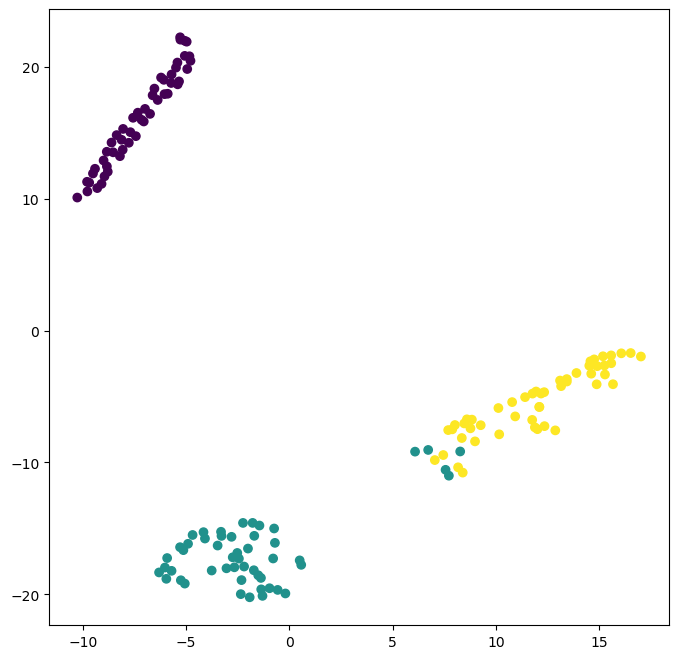

test accuracy: 1.0, test loss: 0.5874888300895691
Kfold: 9


100%|██████████| 14/14 [00:00<00:00, 249.03it/s]


epoch: 0, train: {'accuracy': 0.43703704244560665, 'loss': 1.0818752182854547}, valid: {'accuracy': 0.800000011920929, 'loss': 1.061712622642517}


100%|██████████| 14/14 [00:00<00:00, 236.00it/s]


epoch: 1, train: {'accuracy': 0.785185178120931, 'loss': 1.0029346567613107}, valid: {'accuracy': 0.699999988079071, 'loss': 0.9766807556152344}


100%|██████████| 14/14 [00:00<00:00, 229.96it/s]


epoch: 2, train: {'accuracy': 0.6740740681136096, 'loss': 0.8709134923087226}, valid: {'accuracy': 0.699999988079071, 'loss': 0.8526097536087036}


100%|██████████| 14/14 [00:00<00:00, 401.56it/s]


epoch: 3, train: {'accuracy': 0.7037037081188626, 'loss': 0.8054453863037957}, valid: {'accuracy': 0.8500000238418579, 'loss': 0.8030452728271484}


100%|██████████| 14/14 [00:00<00:00, 234.34it/s]


epoch: 4, train: {'accuracy': 0.792592587294402, 'loss': 0.7658121011875294}, valid: {'accuracy': 0.949999988079071, 'loss': 0.7631743550300598}


100%|██████████| 14/14 [00:00<00:00, 183.93it/s]


epoch: 5, train: {'accuracy': 0.903703698405513, 'loss': 0.7147490006906015}, valid: {'accuracy': 1.0, 'loss': 0.7376695871353149}


100%|██████████| 14/14 [00:00<00:00, 258.54it/s]


epoch: 6, train: {'accuracy': 0.9629629585478041, 'loss': 0.6735510936489811}, valid: {'accuracy': 1.0, 'loss': 0.6610832214355469}


100%|██████████| 14/14 [00:00<00:00, 263.24it/s]


epoch: 7, train: {'accuracy': 0.970370367721275, 'loss': 0.6379115669815628}, valid: {'accuracy': 1.0, 'loss': 0.6416281461715698}


100%|██████████| 14/14 [00:00<00:00, 319.35it/s]


epoch: 8, train: {'accuracy': 0.9555555493743332, 'loss': 0.6192550305966977}, valid: {'accuracy': 1.0, 'loss': 0.6021524667739868}


100%|██████████| 14/14 [00:00<00:00, 255.27it/s]


epoch: 9, train: {'accuracy': 0.970370367721275, 'loss': 0.5995202528105842}, valid: {'accuracy': 1.0, 'loss': 0.5967826843261719}


100%|██████████| 14/14 [00:00<00:00, 248.67it/s]


epoch: 10, train: {'accuracy': 0.9629629563402247, 'loss': 0.5937653206012867}, valid: {'accuracy': 1.0, 'loss': 0.5855202674865723}


100%|██████████| 14/14 [00:00<00:00, 203.74it/s]


epoch: 11, train: {'accuracy': 0.9703703633061161, 'loss': 0.596436756628531}, valid: {'accuracy': 1.0, 'loss': 0.587670087814331}


100%|██████████| 14/14 [00:00<00:00, 210.14it/s]


epoch: 12, train: {'accuracy': 0.970370367721275, 'loss': 0.5855933317431697}, valid: {'accuracy': 1.0, 'loss': 0.5712299942970276}


100%|██████████| 14/14 [00:00<00:00, 319.80it/s]


epoch: 13, train: {'accuracy': 0.9703703633061161, 'loss': 0.58501664797465}, valid: {'accuracy': 1.0, 'loss': 0.577782154083252}


100%|██████████| 14/14 [00:00<00:00, 290.05it/s]


epoch: 14, train: {'accuracy': 0.9629629585478041, 'loss': 0.5846961008177863}, valid: {'accuracy': 1.0, 'loss': 0.5736560821533203}


100%|██████████| 14/14 [00:00<00:00, 242.74it/s]


epoch: 15, train: {'accuracy': 0.9851851816530581, 'loss': 0.5817753098629139}, valid: {'accuracy': 1.0, 'loss': 0.579594612121582}


100%|██████████| 14/14 [00:00<00:00, 347.89it/s]


epoch: 16, train: {'accuracy': 0.9851851816530581, 'loss': 0.5803967846764458}, valid: {'accuracy': 1.0, 'loss': 0.5658859014511108}


100%|██████████| 14/14 [00:00<00:00, 324.92it/s]


epoch: 17, train: {'accuracy': 0.9703703633061161, 'loss': 0.5808969095901206}, valid: {'accuracy': 1.0, 'loss': 0.5658736228942871}


100%|██████████| 14/14 [00:00<00:00, 168.61it/s]


epoch: 18, train: {'accuracy': 0.9851851816530581, 'loss': 0.5816359762792234}, valid: {'accuracy': 1.0, 'loss': 0.5696977972984314}


100%|██████████| 14/14 [00:00<00:00, 232.45it/s]


epoch: 19, train: {'accuracy': 0.9703703633061161, 'loss': 0.5808255849061189}, valid: {'accuracy': 1.0, 'loss': 0.5611602067947388}


100%|██████████| 14/14 [00:00<00:00, 398.63it/s]


epoch: 20, train: {'accuracy': 0.9703703633061161, 'loss': 0.5815188045854922}, valid: {'accuracy': 1.0, 'loss': 0.5691149830818176}


100%|██████████| 14/14 [00:00<00:00, 250.40it/s]


epoch: 21, train: {'accuracy': 0.9703703655136956, 'loss': 0.5812301348756861}, valid: {'accuracy': 1.0, 'loss': 0.5617639422416687}


100%|██████████| 14/14 [00:00<00:00, 315.83it/s]


epoch: 22, train: {'accuracy': 0.9851851816530581, 'loss': 0.5798325604862637}, valid: {'accuracy': 1.0, 'loss': 0.5600008964538574}


100%|██████████| 14/14 [00:00<00:00, 297.17it/s]


epoch: 23, train: {'accuracy': 0.9629629607553836, 'loss': 0.5836308311533045}, valid: {'accuracy': 1.0, 'loss': 0.5551092624664307}


100%|██████████| 14/14 [00:00<00:00, 299.59it/s]


epoch: 24, train: {'accuracy': 0.9629629563402247, 'loss': 0.5847836225121109}, valid: {'accuracy': 1.0, 'loss': 0.5663864612579346}


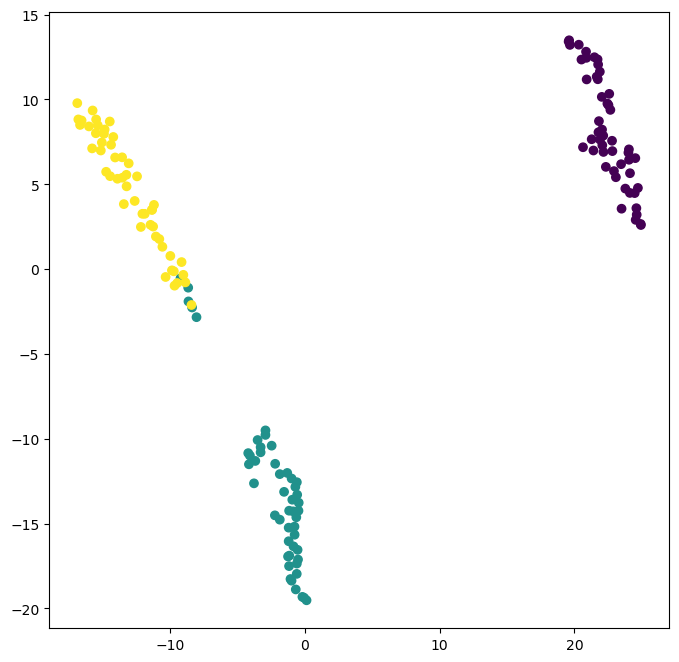

test accuracy: 1.0, test loss: 0.5618478059768677


In [39]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from torch.utils.tensorboard import SummaryWriter

from sklearn.manifold import TSNE

class custom_summary_writer:
    def __init__(self, writer):
        self.writer = writer

    def log(self, metrics):
        for key, value in metrics.items():
            self.writer.add_scalar(key, *(value))

criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pipeline = make_pipeline(StandardScaler())


kFold = KFold(n_splits=10, random_state=42, shuffle=True)

for fold, (train_index, test_index) in enumerate(kFold.split(iris_X)):
    print(f"Kfold: {fold}")
    writer = custom_summary_writer(SummaryWriter(f"runs/iris_experiment_1/fold_{fold}"))

    X_train, X_test, y_train, y_test = (
        iris_X[train_index],
        iris_X[test_index],
        iris_Y[train_index],
        iris_Y[test_index],
    )

    X_train = pipeline.fit_transform(X_train)
    X_test = pipeline.transform(X_test)




    X_train_dataset = IRISDataset(X_train, y_train, tt.Compose([torch.tensor]))
    X_test_dataset = IRISDataset(X_test, y_test, tt.Compose([torch.tensor]))

    train_loader = DataLoader(X_train_dataset, batch_size=10, shuffle=True)
    test_loader = DataLoader(X_test_dataset, batch_size=10, shuffle=False)


    model = SimpleMLP(3)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    history = train(
        model, train_loader, test_loader, optimizer, criterion, device, epochs=25,log_writer = writer
    )

    features_train_data, train_labels , _ = get_features(model, train_loader, device)
    features_test_data, test_labels , test_preds = get_features(model, test_loader, device, get_preds=True)
    features = np.concatenate([features_train_data,features_test_data])
    labels = np.concatenate([train_labels,test_labels])
    plot_TSNE(features, labels,writer=writer.writer)
    

    n_classes = 3
    # plot all the pr curves
    for i in range(n_classes):
        add_pr_curve_tensorboard(i, np.array(test_preds), np.array(test_labels), writer.writer)



    accuracy_test = accuracy(torch.tensor(test_preds), torch.tensor(test_labels))
    loss_test = criterion(torch.tensor(test_preds), torch.tensor(test_labels)).item()
    print(f"test accuracy: {accuracy_test}, test loss: {loss_test}")
    
    writer.log({"test/accuracy": (accuracy_test,0), "test/loss": (loss_test,0)})

    writer.writer.close()